<a href="https://colab.research.google.com/github/cars1015/100knock-data_analytics/blob/main/%E7%AC%AC4%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir='/content/drive/My Drive/データ分析100本ノック/data'
data_dir=os.path.join(dir+'/100knock-data_analytics/4')
os.chdir(data_dir)

ノック31

In [3]:
import pandas as pd
uselog=pd.read_csv("use_log.csv")
uselog.isnull().sum()

,0
log_id,0
customer_id,0
usedate,0


In [4]:
customer=pd.read_csv("customer_join.csv")
customer.isnull().sum()

,0
customer_id,0
name,0
class,0
gender,0
start_date,0
end_date,2842
campaign_id,0
is_deleted,0
class_name,0
price,0


ノック32

In [5]:
customer_clustering=customer[["mean","median","max","min","membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
customer_clustering_sc=sc.fit_transform(customer_clustering)

kmeans=KMeans(n_clusters=4,random_state=42)
clusters=kmeans.fit(customer_clustering_sc)
customer_clustering=customer_clustering.assign(cluster=clusters.labels_)
print(customer_clustering["cluster"].unique())
customer_clustering.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[1 3 2 0]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


ノック33

In [7]:
customer_clustering.columns= ["月内平均値","月内中央値","月内最大値","月内最小値","会員期間","cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,846,846,846,846,846
1,1249,1249,1249,1249,1249
2,1334,1334,1334,1334,1334
3,763,763,763,763,763


In [8]:
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.054608,8.039598,10.009456,6.160757,7.072104
1,4.677494,4.671337,7.232986,2.153723,36.915933
2,5.524239,5.375187,8.745877,2.687406,14.843328
3,3.054713,2.888598,4.756225,1.653997,9.263434


ノック34

In [9]:
from sklearn.decomposition import PCA
x=customer_clustering_sc
pca=PCA(n_components=2)
pca.fit(x)
x_pca=pca.transform(x)
pca_df=pd.DataFrame(x_pca)
pca_df["cluster"]=customer_clustering["cluster"]
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,1
1,-0.707922,-1.799857,1
2,-1.061499,-1.659826,1
3,-1.160764,-1.810139,1
4,-2.017132,-1.670101,1


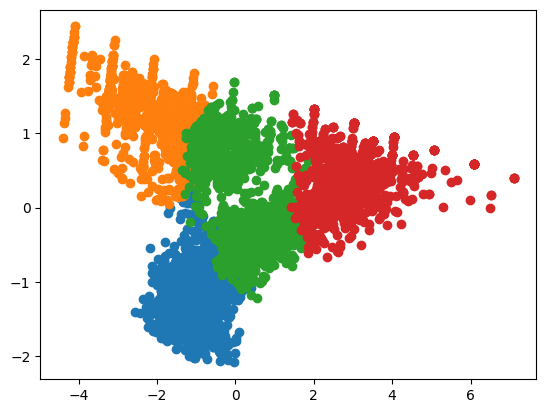

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
  tmp=pca_df.loc[pca_df["cluster"]==i]
  plt.scatter(tmp[0],tmp[1])


ノック35

In [11]:
customer_clustering=pd.concat([customer_clustering,customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,827
1,0,1,19
2,1,0,1230
3,1,1,19
4,2,0,785
5,2,1,549
6,3,1,763


ノック36

In [12]:
uselog["usedate"]=pd.to_datetime(uselog["usedate"])
uselog["年月"]=uselog["usedate"].dt.strftime("%Y%m")
uselog_months=uselog.groupby(["年月","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"},inplace=True)
del uselog_months["usedate"]
uselog_months.head()
#

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [13]:
year_months=list(uselog_months["年月"].unique())
predict_data=pd.DataFrame()
for i in range(6,len(year_months)):
  tmp=uselog_months.loc[uselog_months["年月"]==year_months[i]].copy()
  tmp.rename(columns={"count":"count_pred"},inplace=True)
  for j in range(1,7):
    tmp_before=uselog_months.loc[uselog_months["年月"]==year_months[i-j]].copy()
    del tmp_before["年月"]
    tmp_before.rename(columns={"count":"count_{}".format(j-1)},inplace=True)
    tmp=pd.merge(tmp,tmp_before,on="customer_id",how="left")
  predict_data=pd.concat([predict_data,tmp],ignore_index=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [14]:
predict_data=predict_data.dropna()
predict_data=predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


ノック37

In [15]:
predict_data=pd.merge(predict_data,customer[["customer_id","start_date"]],on="customer_id",how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [16]:
predict_data["now_date"]=pd.to_datetime(predict_data["年月"],format="%Y%m")
predict_data["start_date"]=pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"]=None
for i in range(len(predict_data)):
  delta=relativedelta(predict_data["now_date"][i],predict_data["start_date"][i])
  predict_data.loc[i,"period"]=delta.years*12+delta.months
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


ノック38

In [19]:
predict_data=predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model=linear_model.LogisticRegression()
X=predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y=predict_data["count_pred"]
X_train,X_test,Y_train,Y_test=sklearn.model_selection.train_test_split(X,y,random_state=0)
model.fit(X_train,Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [20]:
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.27037617554858934
0.24647887323943662


In [22]:
coef = pd.DataFrame({
    "feature_names": X.columns,
    "coefficient": model.coef_[0]  # Access coefficients for the first class
})
coef

,feature_names,coefficient
0,count_0,-0.569608
1,count_1,-0.358878
2,count_2,-0.062153
3,count_3,-0.126680
4,count_4,-0.036511
5,count_5,0.174228
6,period,0.624024


ノック40

In [24]:
x1=[3,4,4,6,8,7,8]
x2=[2,2,3,3,4,6,8]
x_pred=pd.DataFrame(data=[x1,x2],columns=["count_0","count_1","count_2","count_3","count_4","count_5","period"])


In [25]:
model.predict(x_pred)

array([2, 1])

In [26]:
uselog_months.to_csv("uselog_months.csv",index=False)